# Sentiment prediction
## UCI Drug Dataset

Load in required libraries 

In [2]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn import naive_bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
import multiprocessing as mp
import csv

In [3]:
# Load Data
df_train = pd.read_csv(
    './project2_data/drugsCom_raw/drugsComTrain_raw.tsv', delimiter='\t', encoding='utf-8')
df_test = pd.read_csv(
    './project2_data/drugsCom_raw/drugsComTest_raw.tsv', delimiter='\t', encoding='utf-8')

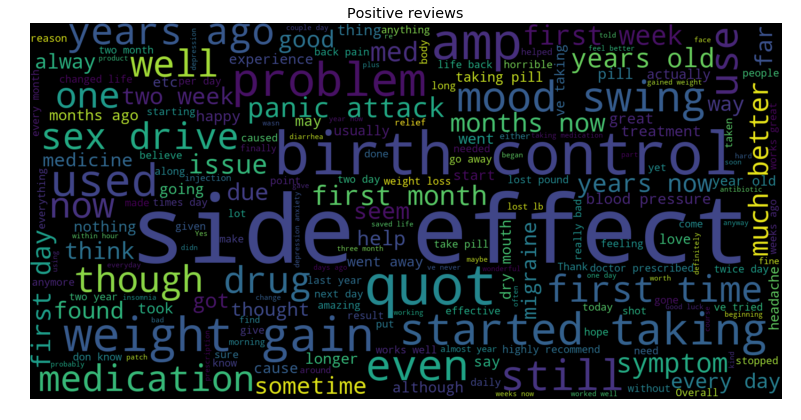

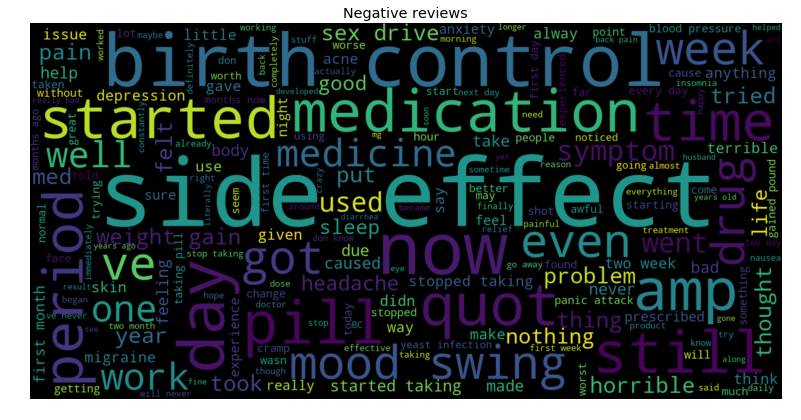

In [4]:
###########################################
#Word Cloud
%matplotlib inline
pos_tweets = df_train[df_train.rating >= 5]
pos_string = []
for t in pos_tweets.review:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Positive reviews')
plt.axis("off")
plt.show()

neg_tweets = df_train[df_train.rating < 5]
neg_string = []
for t in neg_tweets.review:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Negative reviews')
plt.axis("off")
plt.show()

In [5]:
# Pre process the dataset; Remove punctuation marks etc. 
def process_comments(comments):
    pre_comments = []
    for comment in comments:
        comment = comment.replace(',', '')
        comment = comment.replace('.', '')
        comment = comment.replace('(', '')
        comment = comment.replace(')', '')
        comment = comment.replace('"', '')
        comment = comment.replace('&amp;', 'and')
        comment = comment.replace('!', '')
        comment = comment.replace('/', ' ')
        comment = comment.replace('&quot;', ' ')
        comment = comment.replace('&#39;', ' ')
        comment = comment.replace('\n', ' ')
        comment = comment.replace('\r', ' ')
        pre_comments.append(comment)
    return np.array(pre_comments)

# The tf-idf features are extracted as a first resort for the model
def getCommentFeatures(review,df,n_features=1000):
    tvec = TfidfVectorizer(max_features=n_features)
    X = tvec.fit_transform(review).todense().A
    return [X,tvec]

# Discretize the ratings into three classes as specified
def getDiscreteLabels(ratings):
    temp_ratings = ratings.copy()
    for i, curr_rating in enumerate(ratings):
        if (curr_rating >= 7):
            temp_ratings[i] = 1
        elif (curr_rating >= 4):
            temp_ratings[i] = 0
        else:
            temp_ratings[i] = -1

    return temp_ratings

#Training performed on undersampled data: 
#Specifically undersample the positive class becuase it is at least 4 times as big 
def undersample_data(y_in):

    np.random.seed(0)
    n_samples = y_in.shape[0]
    idxs_inclusion = [False]*n_samples
    for i in range(n_samples):
        if(y_in[i] == 1):
            if(np.random.choice(np.arange(5),size=1)==0):
                idxs_inclusion[i] = True
        else:
            idxs_inclusion[i] = True

    return np.array(idxs_inclusion)


In [6]:
review_train = process_comments(df_train.review.values)
review_test = process_comments(df_test.review.values)

### Undersample the data
We first undersampled the data. Specifically the positive class is under sampled to imrpove trainng times. 

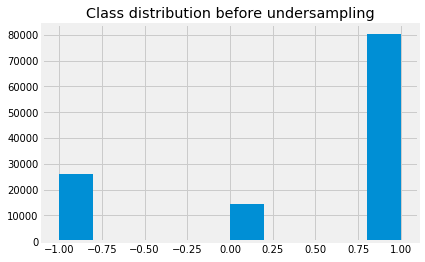

In [7]:
[X,tvec] = getCommentFeatures(review_train, df_train, n_features=1000) # Entire training data
y = getDiscreteLabels(ratings = df_train['rating'].values) # Entire test data

X_test_data = tvec.transform(review_test)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0) # Split for validation

%matplotlib inline
plt.hist(y_train,align = 'mid')
plt.title('Class distribution before undersampling')
plt.show()

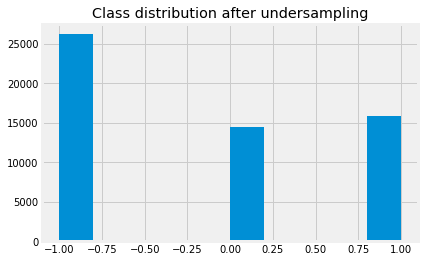

In [8]:
#Undersample the training data
idxs_inclusion = undersample_data(y_train)
X_train = X_train[idxs_inclusion,:]
y_train = y_train[idxs_inclusion]

%matplotlib inline
plt.hist(y_train,align = 'mid')
plt.title('Class distribution after undersampling')
plt.show()

### Try different models as a baseline approach 
We tried the RandomForests and Adaboost methods as part of ensemble methods. 
We also used naive bayes and logistic regression models. 
SVM was not used in the inteerst of training times. 

In [13]:
def getScores(model, model_name, metrics):
    print("Model: ", model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_predict_proba = model.predict_proba(X_test)

    f1 = f1_score(y_test, y_pred, average="weighted")
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(pd.get_dummies(y_test, columns=[-1, 0, 1]).values, y_predict_proba)

    metrics = metrics.append({"Name": model_name, "F1_score": f1, "Accuracy": acc, 'Mean AUC': auc}, ignore_index=True)

    return [y_pred, metrics]

metrics = pd.DataFrame(data=[], columns=["Name", "F1_score", "Accuracy", "Mean AUC"])

rfc = RandomForestClassifier(class_weight='balanced', n_estimators=50)
lg = LogisticRegression(class_weight='balanced')
adb = ensemble.AdaBoostClassifier()
cb = naive_bayes.ComplementNB()

model_names = ["RandomForest", "LogisticRegression", "Adaboost", "ComplementNB"]
models = [rfc, lg, adb, cb]

all_models = zip(models, model_names)
for model, model_name in all_models:
    _, metrics = getScores(model, model_name, metrics)

print(metrics)

Model:  RandomForest
Model:  LogisticRegression


/home/martin/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/martin/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Model:  Adaboost
Model:  ComplementNB
                 Name  F1_score  Accuracy  Mean AUC
0        RandomForest  0.702159  0.687068  0.890074
1  LogisticRegression  0.698759  0.676156  0.824550
2            Adaboost  0.578849  0.559182  0.750791
3        ComplementNB  0.687219  0.673205  0.788143


### DL Model 

In [14]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from os import environ as cuda_environment

cuda_environment["CUDA_VISIBLE_DEVICES"] = str(0)

input_shape = X.shape[1:]

model = Sequential()
model.add(Dense(500, input_shape=input_shape, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(10, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

def getCategorical(y):
    n_samples = y.shape[0]
    y_one_hot = np.zeros((n_samples, 3))
    for i in range(y.shape[0]):
        if (y[i] == 1):
            y_one_hot[i, 0] = 1
        elif (y[i] == 0):
            y_one_hot[i, 1] = 1
        else:
            y_one_hot[i, 2] = 1

    return y_one_hot

def flatten(y_to_flatten):
    ytemp = np.argmax(y_to_flatten, axis=1)
    y_pred_fl = ytemp.copy()
    y_pred_fl[ytemp == 2] = -1
    y_pred_fl[ytemp == 0] = 1
    y_pred_fl[ytemp == 1] = 0

    return y_pred_fl


Train on 56603 samples, validate on 40325 samples
Epoch 1/10
56603/56603 [==============================] - 5s 90us/sample - loss: 0.8317 - acc: 0.6246 - val_loss: 0.7634 - val_acc: 0.6766
Epoch 2/10
56603/56603 [==============================] - 5s 89us/sample - loss: 0.7400 - acc: 0.6788 - val_loss: 0.7286 - val_acc: 0.6946
Epoch 3/10
56603/56603 [==============================] - 5s 88us/sample - loss: 0.6586 - acc: 0.7249 - val_loss: 0.7592 - val_acc: 0.6816
Epoch 4/10
56603/56603 [==============================] - 5s 85us/sample - loss: 0.5588 - acc: 0.7761 - val_loss: 0.6834 - val_acc: 0.7260
Epoch 5/10
56603/56603 [==============================] - 5s 84us/sample - loss: 0.4606 - acc: 0.8225 - val_loss: 0.7628 - val_acc: 0.7041
Epoch 6/10
56603/56603 [==============================] - 5s 84us/sample - loss: 0.3828 - acc: 0.8572 - val_loss: 0.7164 - val_acc: 0.7352
Epoch 7/10
56603/56603 [==============================] - 5s 84us/sample - loss: 0.3245 - acc: 0.8802 - val_loss: 0.

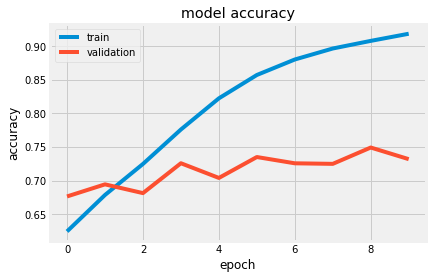

                 Name  F1_score  Accuracy  Mean AUC
0        RandomForest  0.702159  0.687068  0.890074
1  LogisticRegression  0.698759  0.676156  0.824550
2            Adaboost  0.578849  0.559182  0.750791
3        ComplementNB  0.687219  0.673205  0.788143
4                 ANN  0.748299  0.732052  0.368712


In [15]:
cat_y_train = getCategorical(y_train)
cat_y_test = getCategorical(y_test)

history = model.fit(X_train, cat_y_train, epochs=10, validation_data=(X_test, cat_y_test))

%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

cat_y_pred = model.predict(X_test)
y_pred = flatten(cat_y_pred)

f1 = f1_score(y_test, y_pred, average="weighted")
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(pd.get_dummies(y_test, columns=[-1, 0, 1]), cat_y_pred)
metrics = metrics.append({"Name": "ANN", "F1_score": f1, "Accuracy": acc, "Mean AUC": auc}, ignore_index=True)

print(metrics)

### Word embedding 

We first tried to look whether the individual drug-names had some inherent rating to them that would help the classification. 
For that we read out the individual drug-names and compute their mean rating. Then we predict the rating on the validation set. 
If we haven't encountered a drug-name, we give it the overall mean rating

In [16]:
df_train_1 = pd.read_csv(
'./project2_data/drugsCom_raw/drugsComTrain_raw.tsv', delimiter='\t', encoding='utf-8')
df_test = pd.read_csv(
'./project2_data/drugsCom_raw/drugsComTest_raw.tsv', delimiter='\t', encoding='utf-8')


df_train, df_valid = train_test_split(df_train_1, random_state=42)

# Some Drug-Names appear multiple time in a non-unique fashion.
# e.g. "Stalevo", "Stalevo 200"
drug_names_raw = df_train.drugName.unique()
drug_names = np.copy(drug_names_raw)

for idx1, drug1 in enumerate(drug_names_raw):
    for idx2, drug2 in enumerate(drug_names_raw):
        if drug1 in drug2 and drug1 != drug2 and drug2 in drug_names:
            idx_ = np.where(drug_names == drug2)
            drug_names = np.delete(drug_names, idx_)

print(f'Deleted {len(drug_names_raw) - len(drug_names)} duplicate drug_names')


Deleted 507 duplicate drug_names


In [19]:
# Find the mean rating of all drugs:
mean_rating = np.mean(df_train.rating)

# Find mean Rating for each Drugname
drug_ratings = {}
for drug_name in drug_names:
    idxs = [drug_name in name for name in df_train.drugName.values]
    ratings = df_train.rating[idxs]
    mean_rating = np.mean(ratings)
    drug_ratings[drug_name] = mean_rating
print('Found the mean ratings for each drug')

# Find ratings for df_valid
valid_ratings = []
num_not_found = 0
for valid_drug in df_valid.drugName:
    ratings = []
    # The drug listing could contain multiple drugs
    # e.g. 'drug A, drug B'
    # we take the average rating of each drug
    for key in drug_ratings.keys():
        if key in valid_drug:
            ratings.append(drug_ratings[key])

    # If no drug with that name is found then the rating is set to the mean rating
    if ratings == []:
        ratings.append(mean_rating)
        num_not_found += 1
    rating = np.mean(ratings)
    valid_ratings.append(rating)
print(np.mean(valid_ratings))
print(f'Number of not found drugs {num_not_found}')
print(f'MSE: {mean_squared_error(df_valid.rating.values, valid_ratings)}')

def to_labels(ratings):
    labels = []
    for rating in ratings:
        if rating > 7:
            label = 0
        elif rating < 4:
            label = 2
        else:
            label = 1
        labels.append(label)
    return labels

valid_true_labels = to_labels(df_valid.rating.values)
valid_pred_labels = to_labels(valid_ratings)
print(f'Accuracy: {accuracy_score(valid_true_labels, valid_pred_labels):.3} - f1: {f1_score(valid_true_labels, valid_pred_labels, average="micro"):.3}')

Found the mean ratings for each drug
7.004101176309102
Number of not found drugs 220
MSE: 9.565530374262849
Accuracy: 0.498 - f1: 0.498


We found some pretrained Wordvectors which where trained using the GLOVE method. Instead of cumbersomely training our own vectors we downloaded the  word-embeddings and used them for later training

In [20]:
! wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
! mkdir -p project2_data/glove
! unzip -d project2_data/glove/ glove.twitter.27B.zip
vocab_size = 10000
vector_length = 25
max_seq_length = 500
glove_embeddings = pd.read_csv('project2_data/glove/glove.twitter.27B.25d.txt',
                               header=None, delimiter=' ', encoding='utf-8', quoting=csv.QUOTE_NONE)
print('Loaded glove embeddings')
glove_embeddings = glove_embeddings[:vocab_size]

glove_word = glove_embeddings[0]

glove_vectors = glove_embeddings.iloc[:, 1:].values
M1 = np.zeros((vocab_size + 1, vector_length + 1))
M1[:-1, :-1] = glove_vectors
glove_vectors = M1
glove_vectors[-1, -1] = 1

Loaded glove embeddings


In [21]:
def process_chunk(comments):
    processed_comments = []
    lookup = {}
    for comment in comments:
        idxs = []

        comment = comment.replace('&#39;', "'")
        comment = comment.replace('\n', ' ')
        comment = comment.replace('\r', ' ')
        comment = comment.replace('&amp;', ' and ')
        comment = comment.replace('&quot;', ' ')

        for i, word in enumerate(comment.split(' ')):
            # if the comment is longer than the max-seq-length break the  loop
            if i > max_seq_length:
                break

            # put everything into lowercase
            word = word.lower()

            # if empty word skip
            if word == '':
                continue
            # if word is in our lookup table
            if word in lookup.keys():
                idx = lookup[word]
            else:
                try:
                    idx = glove_word[glove_word == word].index[0]
                except IndexError:
                    idx = vocab_size
                # put word into lookup table
                lookup[word] = idx
            idxs.append(idx)
        processed_comments.append(idxs)
    processed_comments = keras.preprocessing.sequence.pad_sequences(
        processed_comments,
        maxlen=max_seq_length,
        padding='post',
        truncating='post',
        value=0
    )
    return processed_comments


def comments_to_idxs(comments):
    cores = mp.cpu_count()
    pool = mp.Pool(cores)
    chunks = np.array_split(comments, cores)
    results = pool.map(process_chunk, chunks)
    results = np.vstack(results)
    return results

In this step we create find the indices for each word. Each sentence get's cut to the length of 50 word and if it's shortet it gets padded to the length of 50. 
We train a Bidirectional LSTM-RNN to predict the class of the individual drug-rating

In [24]:
train_idxs_1 = process_chunk(review_train)
test_idxs = process_chunk(review_test)

np.save('project2_data/glove/train_idxs.npy', train_idxs)
np.save('project2_data/glove/test_idxs.npy', test_idxs)

#train_idxs_1 = np.load('project2_data/glove/train_idxs.npy')
#test_idxs = np.load('project2_data/glove/test_idxs.npy')

max_seq_length = 50
train_idxs_1 = train_idxs_1[:, :max_seq_length] # Entire training data
test_idxs = test_idxs[:, :max_seq_length] # Entire test data 

train_idx, valid_idx, train_y, valid_y = train_test_split(
    train_idxs_1, df_train_1.rating.values, random_state=42)
train_y_cat = pd.get_dummies(getDiscreteLabels(train_y)).values
valid_y_cat = pd.get_dummies(getDiscreteLabels(valid_y)).values

# Bidiretional LSTM

batch_size = 64
hidden_units = 256
epochs = 20

sequence_input = keras.layers.Input(shape=(max_seq_length,))
embedding_sequence = keras.layers.Embedding(
    vocab_size + 1,
    vector_length + 1,
    weights=[glove_vectors],
    input_length=max_seq_length,
    trainable=False
)(sequence_input)

lstm = keras.layers.Bidirectional(
    keras.layers.LSTM(hidden_units))(embedding_sequence)
drop = keras.layers.Dropout(0.5)(lstm)
dense = keras.layers.Dense(128)(drop)
out = keras.layers.Dense(3, activation='softmax')(dense)
model = keras.models.Model(inputs=sequence_input, outputs=out)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.fit(x = train_idx,y = train_y_cat,validation_data=(valid_idx, valid_y_cat),epochs=epochs)
model.save('model_cat.h5')

In [25]:
model = keras.models.load_model('model_cat.h5')
print('loaded model')

lstm_predictions = model.predict(valid_idx)
valid_y_cat = pd.get_dummies(to_labels(valid_y)).values
print(f'ROC AUC {roc_auc_score(valid_y_cat, lstm_predictions):.3}  Acc: {accuracy_score(np.argmax(valid_y_cat, axis=1), np.argmax(lstm_predictions, axis=1)):.3} ')

loaded model
ROC AUC 0.772  Acc: 0.66 


In [26]:
lstm_test_predictions = model.predict(test_idxs)
test_y_cat = pd.get_dummies(to_labels(df_test.rating.values)).values
roc_auc = roc_auc_score(test_y_cat, lstm_test_predictions)
f1 = f1_score(np.argmax(test_y_cat, axis=1), np.argmax(lstm_test_predictions, axis=1), average='weighted')
accuracy = accuracy_score(np.argmax(test_y_cat, axis=1), np.argmax(lstm_test_predictions, axis=1))
print(f'ROC AUC {roc_auc:.3}  Acc: {accuracy:.3}  f1:{f1:.3}')

ROC AUC 0.769  Acc: 0.658  f1:0.657


In [27]:
metrics = metrics.append({"Name": "LSTM", "F1_score": f1, "Accuracy": accuracy, "Mean AUC": roc_auc}, ignore_index=True)
metrics

,Name,F1_score,Accuracy,Mean AUC
0,RandomForest,0.702159,0.687068,0.890074
1,LogisticRegression,0.698759,0.676156,0.824550
2,Adaboost,0.578849,0.559182,0.750791
3,ComplementNB,0.687219,0.673205,0.788143
4,ANN,0.748299,0.732052,0.368712
5,LSTM,0.657449,0.658074,0.769206


# Conclusion

- We did intial pre processing of the reviews received for each drug i.e. removal of punctuation marks. 
- We then used TF-IDF as a baseline approach for feature selection method. Basic models such as ensemble methods, logistic regression and Naive Bayes models were tested. 
- We also implemented a simple multilayer perceptron (ANN) in the hope of increasing our baseline score. 
- We also hypotheiszed that a drug name could be a strong indicator for the label. 
- However our F1 score was close to 0.5 suggesting a random behaviour and hence concluded it may not be effective after all. 
- We then implemented a word embedding approach and implemented a bi directional LSTM. However it was outperformed by simpler models. 